## Exp.10. 인공지능으로 세상에 없던 새로운 패션 만들기
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.<br>
오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.<br>
<br>
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.<br>
gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.<br>
<br>
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.<br>
제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.<br>

### 1. 라이브러리 import

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


### 2. data 로드 및 전처리

In [2]:
# load data

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()


4431872/4422102 [==============================] - 0s 0us/step


max pixel: -0.99215686
min pixel: -1.0078431
max pixel: -1.0077816
min pixel: -1.0079046


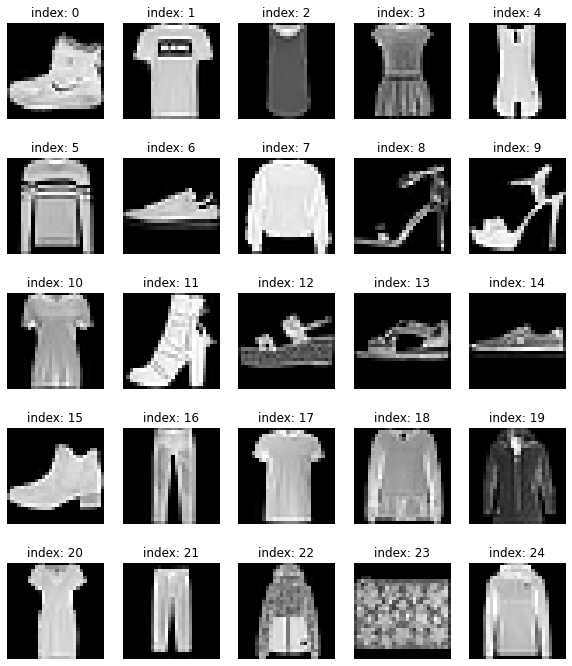

In [5]:
# data 전처리 :: data 정규화
# 이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 
# 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
    
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())


# data 전처리 :: data 분석
# Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이죠. 
# 따라서 데이터셋의 shape 마지막에 1을 추가해 주도록 하겠습니다.
train_x.shape # (60000, 28, 28)
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape # (60000, 28, 28, 1)


# data 전처리 :: data 확인 
plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off') # 여기에서는 필요하지 않은 축을 지워서 깔끔하게 나타냈습니다
plt.show()


# data전처리 완료 !!!!

In [4]:
# daata를 dataset에 넣는다. 
#
# 정리된 데이터를 곧 모델에 넣어서 학습시켜야 하니, 
# 편하게 사용할 수 있도록 텐서플로우의 Dataset을 이용해 준비해 놓도록 하겠습니다. 
# 이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 됩니다

BUFFER_SIZE = 60000 
BATCH_SIZE = 256  # 모델이 한 번에 학습할 데이터의 양 (미니 배치 학습 방법 이용)

# train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 
# 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.
train_dataset = \
tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("DAta 전처리 완료 !!!!!")

DAta 전처리 완료 !!!!!


### 3. Generator(생성자) 생성

In [5]:
# 생성자 모델을 만드는 합수
 
# DCGAN 입니다. Deep Convolutional GAN
# important layer : Conv2DTranspose 레이어
#                   Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다.
#                   (7, 7, 256) => (7, 7, 128) → (14, 14, 64) → (28, 28, 1)
# 참고자료 : https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko

# Q16. 생성자의 입력 벡터는 어떤 형태입니까?
#      모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받습니다

# Q17. 처음 입력된 벡터는 어떤 레이어를 지나며, 첫 레이어를 지난 후의 shape는 어떤 형태입니까?
#      입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 
#      첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됩니다.

# Q18. 첫 번째 레이어를 지난 후 벡터는 어떤 층을 지나게 됩니까? 이 레이어는 왜 필요합니까?
#      첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 됩니다.
#      이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 
#      (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업입니다.

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, 
                                     activation='tanh'))

    return model

# BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다. 
# 중간층들의 활성화 함수는 모두 LeakyReLU를 사용하였습니다. 
# 다만 마지막 층에는 활성화 함수로 tanh를 사용하는데, 
# 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [6]:
# Generator 생성 및 확인

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### 4. Discriminator (판별자) 생성
 **입력**은 (28, 28, 1) 크기의 이미지가, **출력**은 단 하나의 숫자(진짜라고 판단하는 정도)

In [7]:
# 판별자 모델을 만드는 합수

# 첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층들을 거치며 
# (28, 28, 1) → (14, 14, 64) → (7, 7, 128) 형태로 줄어든다.

# 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환
# 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [8]:
# Discriminater 생성 및 확인

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

### 5. 중간 테스트 
생성자와 판별자의 중간 작동 시험 입니다. 

In [9]:
# 생성자 테스트 작업 1/2
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보기.

# 텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 
# 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됩니다 
# (내부적으로는 생성자의 call 함수가 호출됩니다).

# 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다! 
# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

# 결과 : TensorShape([1, 28, 28, 1])
#       첫 번째 1은 1개(batch_size=1)라는 뜻
#       (28, 28, 1)은 해당 사이즈의 이미지가 생성되었다는 뜻



TensorShape([1, 28, 28, 1])

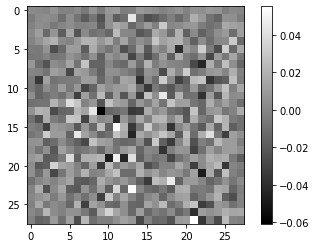

In [10]:
# 생성자 테스트 작업 2/2
# 이미지 시각화

# matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 
# (28, 28) shape의 이미지를 꺼낼 수 있도록 해야 합니다.
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [11]:
# discriminator 작동 테스트 

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00042499]], dtype=float32)>

### 6. loss function

In [12]:
# loss fn 만들기 

# fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
# real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
    
# tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 
# 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다. 따라서 from_logits를 True로 설정해 주어야 
# BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 
# 알맞게 계산할 수 있습니다
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    
# 생성자의 loss fn : 생성자가 만든 이미지에 대한 fake_output이 판별자가 판단 했을 때 
#                  모두 True가 되도록 이미지를 만들어야 하므로 아래와 같이 구성 한다. 
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# 판별자의 loss fn : 판별자는 fake인 이미지는 fake로 real 이미지인 경우에는 real로 판별해야 하므로 
#                  아래와 같이 구성한다.  
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


# tf.ones_like()와 tf.zeros_like() 함수는...
# parameter로 들어온 벡터와 동일한 크기이면서 값은 1(ones_like()) 또는 0(zeros_like())으로 
# 가득 채워진 벡터를 만들고 싶을 때 사용합니다.

### 7. discriminator accuracy
판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.<br>
real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

In [13]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# ************************************************************************************************************
# ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,
#
# (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : 
#                 real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
#
# (2) tf.cast( (1), tf.float32) : 
#                 (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
#
# (3) tf.reduce_mean( (2)) : 
#                 (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5
# ************************************************************************************************************

### 8. 최적화 함수(optimizer) 및 확인용 sample 생성정보(seed값) 정의
Adam 함수 또한 tf.keras.optimizers 안에 있습니다.<br>
중요한 하이퍼 파라미터인 **"learning rate"**는 **0.0001**로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.<br>
또한, 중요한 점 한 가지는 **생성자와 구분자**는 따로따로 학습을 진행하는 **개별 네트워크**이기 때문에 **optimizer를 따로 만들어주어야 한다**는 점입니다.<br><br>
학습이 잘 진행 되는 지 확인 하기위하여 한번에 16장의 샘플을 지정 하여 생성하겠습니다.<br>
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, **고정된 seed 노이즈**를 만들어두어야 합니다.<br>
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다

In [14]:
# optimizer 생성
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 확인용 샘플 생성 정보 (미리 만들어 놓는다)
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 9. 잠깐만 : python decorator (데코레이터),  @tf.function
**tf.function :** Compiles a function into a callable TensorFlow graph<br><br>
Numpy array 입력 x, y를 동일하게 사용했지만 f(x,y)의 결과 타입은 다릅니다. **@tf.function 데코레이터**가 사용된 함수에 입력된 입력은 **Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환**됩니다. 알아두면 향후 Tensorflow 모델 구현에 매우 편리하게 사용할 수 있을 것 같습니다.

In [15]:
# decorator @tf.function의 사용예

import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

### 10.  한 단계씩 학습할 train_step 함수

In [16]:
# **************************************************************************************
# train_step fn 설명
# **************************************************************************************
# (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
# (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
# (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
# (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
# (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
# (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
# (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
# (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
# (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
# (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 11. 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성 및 저장 하는 함수

In [17]:

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 12.  loss와 accuracy 그래프
학습 과정을 체크하기 위해 **시각화**해 보아야 할 중요한 것으로 **loss**와 **accuracy** 그래프이다. <br>
GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 **두 모델이 서로의 학습 과정에 영향을 주고받기 때문**입니다.<br> 
train_step() 함수가 리턴하는 **gen_loss**, **disc_loss**, **real_accuracy**, **fake_accuracy** 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하여 저장 하는 함수

In [18]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 13. checkpoint (정기적으로 모델을 저장하기 위해...) 

In [19]:
import os

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 이것만 하면 모두 저장이 된다 말인가????

## 14. 모델 학습 !!!

In [20]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [21]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

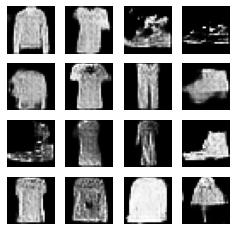

Time for training : 1538 sec


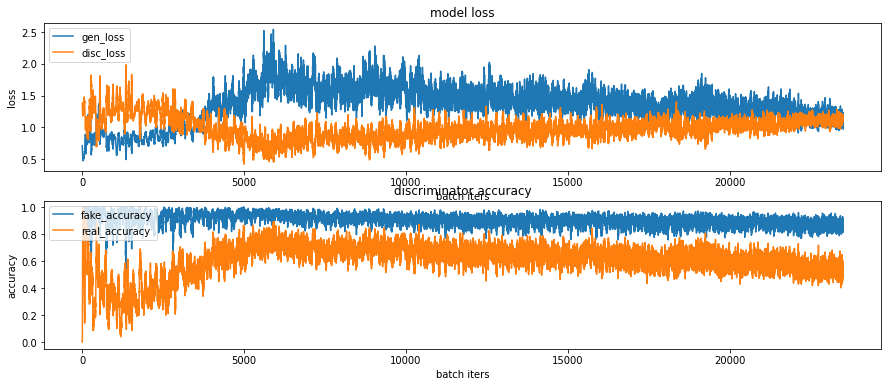

CPU times: user 13min 20s, sys: 2min 37s, total: 15min 58s
Wall time: 25min 40s


In [22]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 15. 학습과정 시각화

In [23]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1518685 Feb 15 15:28 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


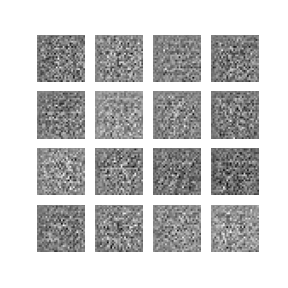